In [1]:
!pip install mplfinance
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [4]:
import mplfinance as mpf
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
@nb.jit(nopython=True)
def divide_to_bins(highest: float, lowest: float, bins: int, intervals: np.ndarray) -> None:
    """
    This method is used to divide the price range into bins
    """
    gap = (highest - lowest) / bins
    for index in range(bins):
        update_lower_bound(index, lowest + index * gap, intervals)
        update_upper_bound(index, lowest + (index + 1) * gap, intervals)
        
@nb.jit(nopython=True)
def distribute_volume_to_bins(stand_price: np.ndarray, intervals: np.ndarray) -> None:
    sorted_indices = np.argsort(stand_price)
    for index in range(len(intervals[0])):
        lower_bound = get_lower_bound(index, intervals)
        upper_bound = get_upper_bound(index, intervals)
        for s_index in sorted_indices:
            price = stand_price[s_index]
            if lower_bound <= price < upper_bound:
                accumulate_volume(index, 1, intervals)
        
@nb.jit(nopython=True)        
def update_upper_bound(index: int, value: float, intervals: np.ndarray) -> None:
    """
    This method is used to update the upper bound of each bin in the value area
    """
    intervals[1][index] = value

@nb.jit(nopython=True)
def update_lower_bound(index: int, value: float, intervals: np.ndarray) -> None:
    """
    This method is used to update the lower bound of each bin in the value area
    """
    intervals[0][index] = value
    
@nb.jit(nopython=True)
def get_lower_bound(index: int, intervals: np.ndarray):
    """
    This method is used to get the lower bound of the bins
    """
    return intervals[0][index]

@nb.jit(nopython=True)
def get_upper_bound(index: int, intervals: np.ndarray):
    """
    This method is used to get the upper bound of the bins
    """
    return intervals[1][index]

@nb.jit(nopython=True)
def accumulate_volume(index: int, value: float, intervals: np.ndarray) -> None:
    """
    This method is used to accumulate the volume in the bins
    """
    intervals[2][index] += value

@nb.jit(nopython=True)   
def get_repr_price(intervals: np.ndarray) -> np.ndarray:
    """
    This method is used to get the representative price of the volume bins
    """
    return (intervals[0] + intervals[1]) / 2

In [6]:
@nb.jit(nopython=True)
def transform_data(data, timeframe, bins):
    len_ = data.shape[1]
    max_groups = len_  # Maximum possible groups, assuming each data point could form a group
    
    # Preallocate arrays with maximum possible size
    result_preallocated = np.empty((max_groups, 7), dtype=np.float64)
    distribution_preallocated = np.empty((max_groups, bins), dtype=np.float64)
    
    group_count = 0  # Counter for actual number of groups processed
    start_ind = 0  # Start index for each group
    
    # Loop through data to identify groups and calculate their statistics and distributions
    for index in range(1, len_ + 1):  # Include an extra step to handle the last group
        # Determine if this index is the start of a new group or the end of the data
        if index == len_ or (data[0, index] // timeframe) != (data[0, index - 1] // timeframe):
            # Calculate statistics for the current group
            high = np.max(data[1, start_ind:index])
            low = np.min(data[1, start_ind:index])
            intervals = np.zeros((3, bins), dtype=np.float64)
            divide_to_bins(high, low, bins, intervals)
            distribute_volume_to_bins(data[1, start_ind:index], intervals)
            distribution = intervals[2] / np.sum(intervals[2]) if np.sum(intervals[2]) > 0 else intervals[2]
            
            # Store results in the preallocated arrays
            result_preallocated[group_count] = [
                data[0, start_ind],  # Time
                data[1, start_ind],  # Open
                high,  # High
                low,  # Low
                data[1, index - 1],  # Close
                index - start_ind,  # Volume (tick-volume)
                np.argmax(data[1, start_ind:index]) > np.argmin(data[1, start_ind:index]),  # Order
            ]
            distribution_preallocated[group_count] = distribution
            
            start_ind = index  # Update start index for the next group
            group_count += 1  # Increment the group counter
    
    # Trim the preallocated arrays to the actual number of groups processed
    result = result_preallocated[:group_count]
    distribution = distribution_preallocated[:group_count]
    return result, distribution

In [7]:
data = np.load(r'./EURUSD.npy')

In [60]:
tdata, dist = transform_data(data.T, 1800, 10)

In [61]:
dist[0]

array([0.01944444, 0.02777778, 0.01944444, 0.01111111, 0.        ,
       0.00555556, 0.15555556, 0.28333333, 0.35555556, 0.12222222])

In [62]:
df = pd.DataFrame(tdata[:,:6], columns = ['Time', 'Open', 'High', 'Low', 'Close' , 'Volume'])
df['Time'] = pd.to_datetime(df['Time'], unit='s')

In [63]:
df[['Time']].head(50)

,Time
0,2010-01-01 00:00:03.964000000
1,2010-01-01 00:30:08.670000128
2,2010-01-01 01:00:08.052000000
3,2010-01-01 01:30:00.900999936
4,2010-01-01 02:00:05.030999808
5,2010-01-01 02:30:04.631000064
6,2010-01-01 03:00:03.576000000
7,2010-01-01 03:30:04.013999872
8,2010-01-01 04:00:01.296999936
9,2010-01-01 04:30:17.418999808


In [64]:
# filter all data in time of newyork time
df_NY = df[(df['Time'].dt.hour >=13) & (df['Time'].dt.hour < 22)]

In [65]:
import pandas as pd
import numpy as np

def assign_labels(df, k, gap):
    """
    Assigns a label of 1 if, within the next k sessions, the High price is more than 5% above the current Close price,
    or the Low price is more than 5% below the current Close price. Otherwise, assigns a label of 0.

    Args:
    - df (pd.DataFrame): DataFrame containing the 'High', 'Low', and 'Close' columns.
    - k (int): Number of future sessions to check.

    Returns:
    - pd.DataFrame: DataFrame with an additional 'labels' column.
    """
    n = len(df)
    labels = np.zeros(n)  # Initialize the labels array with zeros

    # Iterate through the DataFrame up to the penultimate 'k' rows
    for i in range(n - k):
        # Future 'k' High and Low prices
        high_future = df['High'].iloc[i + 1:i + 1 + k]
        low_future = df['Low'].iloc[i + 1:i + 1 + k]
        close_current = df['Close'].iloc[i]
        
        # Check conditions
        condition_high = (high_future > close_current * (1+ gap/100)).any()
        condition_low = (low_future < close_current * (1- gap/100)).any()
        
        # If any condition is met, assign label 1
        if condition_high or condition_low:
            labels[i] = 1

    # Assign labels to the DataFrame
    df['labels'] = labels
    return df





In [58]:
# Example usage
# 1h and predict next 10h with gap is 2%
gap = 2
k = 10  # Number of future sessions to check

df = assign_labels(df, k,gap)
df_1 = df[df['labels'] > 0]
len(df_1)

149

In [73]:
# Example usage
# 1h and predict next 10h with gap is 0.5%
gap = 0.5
k = 50 # Number of future sessions to check

df = assign_labels(df, k,gap)
df_11= df[df['labels'] > 0]
len(df_11)

95923

In [74]:
# filter all data in time of newyork time
df_NY = df[(df['Time'].dt.hour >=13) & (df['Time'].dt.hour < 22)]
df_11= df_NY[df_NY['labels'] > 0]
len(df_11)

35881

In [82]:
# Example usage
# 1h and predict next 10h with gap is 0.5%
gap = 2
k = 240 # Number of future sessions to check

df = assign_labels(df, k,gap)
df_11= df[df['labels'] > 0]
len(df_11)

32568

In [83]:
df_11['Hour'] = df_11['Time'].dt.hour
labels_1_by_hour = df_11.groupby('Hour').size()

/var/folders/36/0wtx40391jvctpbt56xjhn2c0000gn/T/ipykernel_71258/3938172139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Hour'] = df_11['Time'].dt.hour


In [85]:
# Tính phút từ cột 'Time' để xác định nhãn 1 rơi vào 30 phút đầu hay cuối
df_11['Minute'] = df_11['Time'].dt.minute

# Tạo một cột mới để phân biệt 30 phút đầu (0) và 30 phút cuối (1) của mỗi giờ
df_11['Half_Hour'] = (df_11['Minute'] >= 30).astype(int)

# Thống kê số lượng nhãn 1 trong mỗi giờ, phân biệt 30p đầu và cuối
labels_1_half_hour_stats = df_11[df_11['labels'] == 1.0].groupby(['Hour', 'Half_Hour']).size().unstack(fill_value=0)

labels_1_half_hour_stats


/var/folders/36/0wtx40391jvctpbt56xjhn2c0000gn/T/ipykernel_71258/2372992724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Minute'] = df_11['Time'].dt.minute
/var/folders/36/0wtx40391jvctpbt56xjhn2c0000gn/T/ipykernel_71258/2372992724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Half_Hour'] = (df_11['Minute'] >= 30).astype(int)


Half_Hour,0,1
Hour,,
0,676,691
1,684,674
2,678,681
3,685,698
4,708,694
5,693,696
6,696,684
7,697,693
8,684,689


In [84]:
labels_1_by_hour

Hour
0     1367
1     1358
2     1359
3     1383
4     1402
5     1389
6     1380
7     1390
8     1373
9     1386
10    1366
11    1360
12    1366
13    1348
14    1309
15    1319
16    1345
17    1357
18    1349
19    1352
20    1331
21    1317
22    1340
23    1322
dtype: int64

In [80]:
# filter all data in time of newyork time
df_NY = df[(df['Time'].dt.hour >=13) & (df['Time'].dt.hour < 22)]
df_11= df_NY[df_NY['labels'] > 0]
len(df_11)

12027

In [81]:
len(df_NY)

63424

# Function help to extract next 

In [39]:
labels_counts = df['labels'].value_counts(normalize=True)
labels_ratio = labels_counts.get(0, 0) / labels_counts.get(1, 0) if labels_counts.get(1, 0) != 0 else float('inf')

labels_ratio


inf

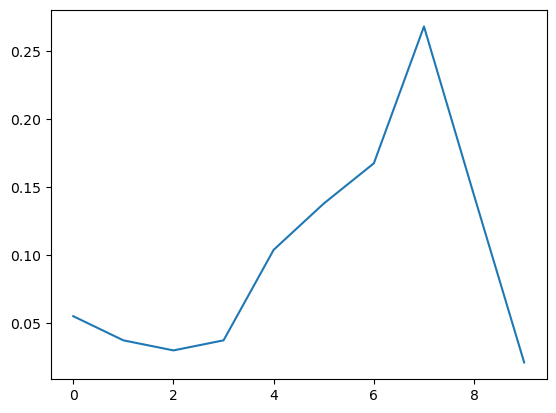

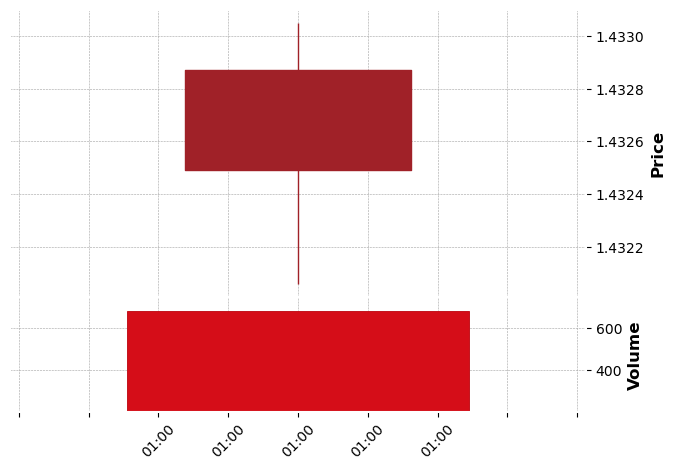

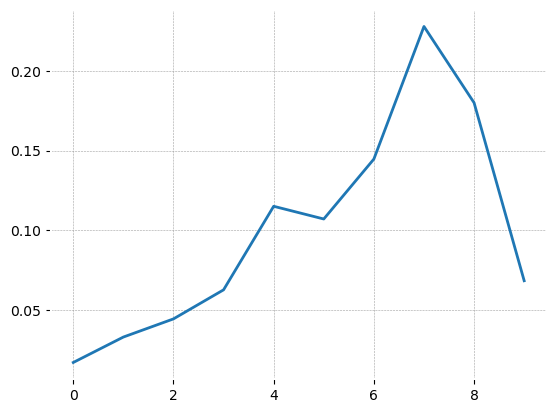

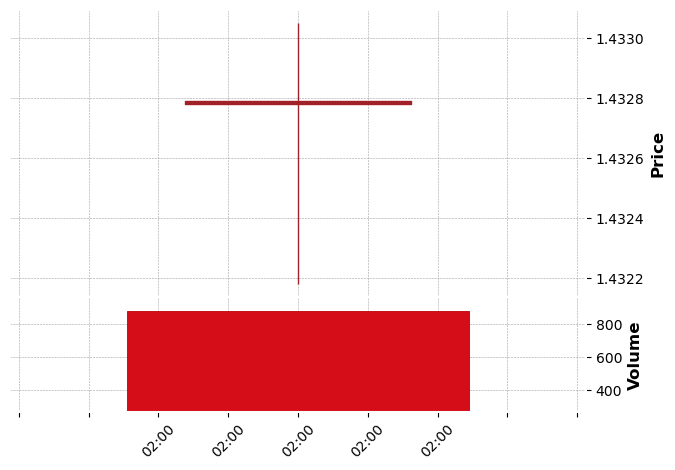

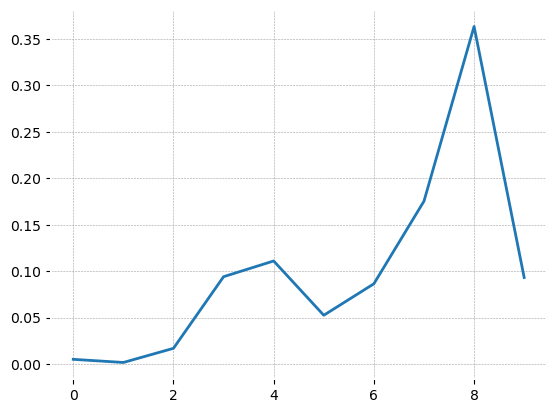

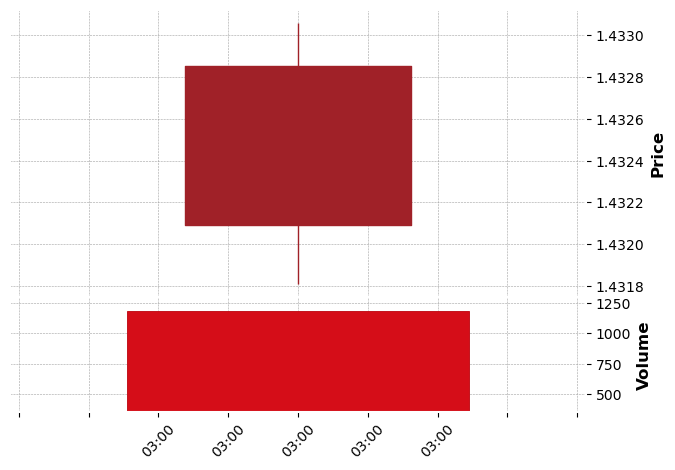

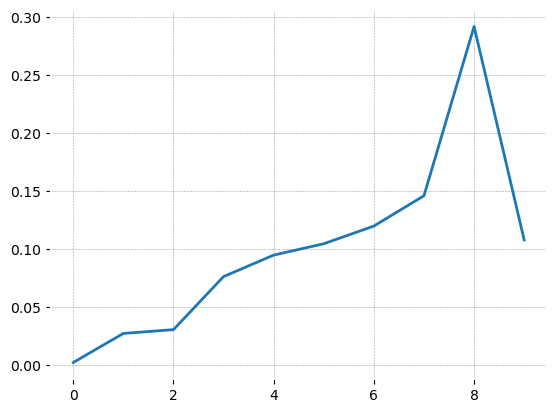

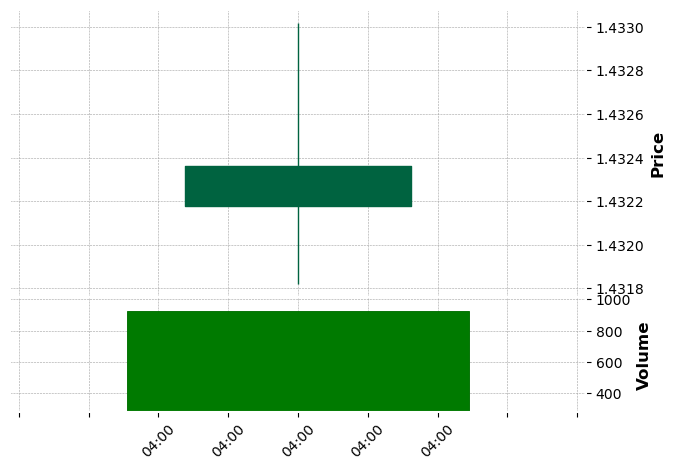

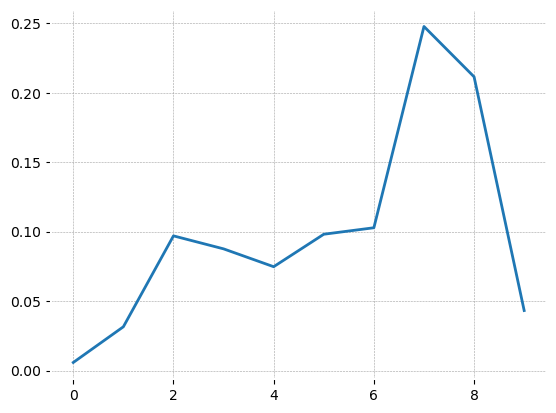

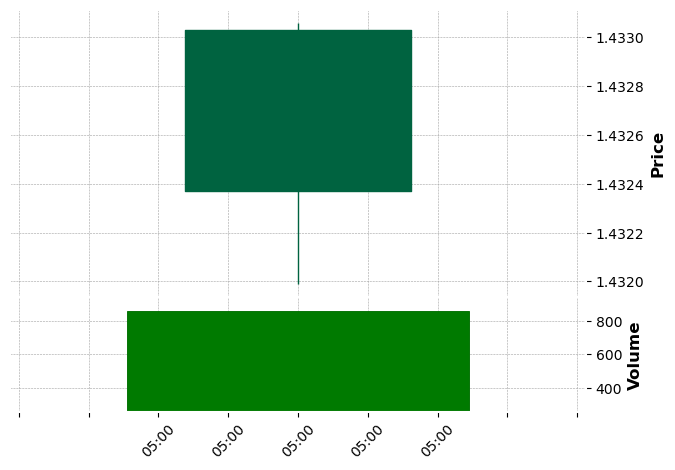

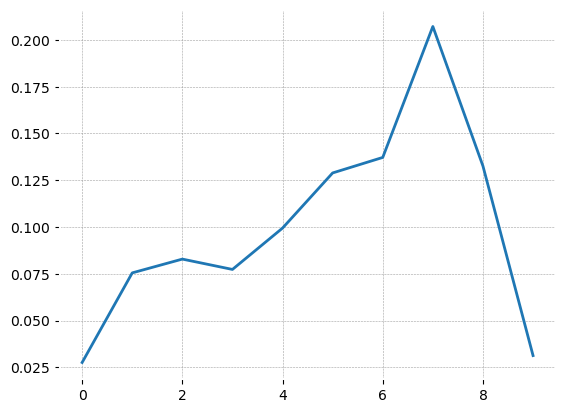

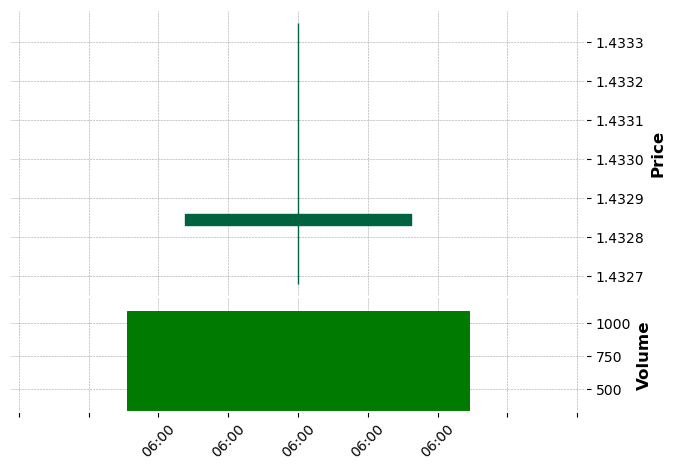

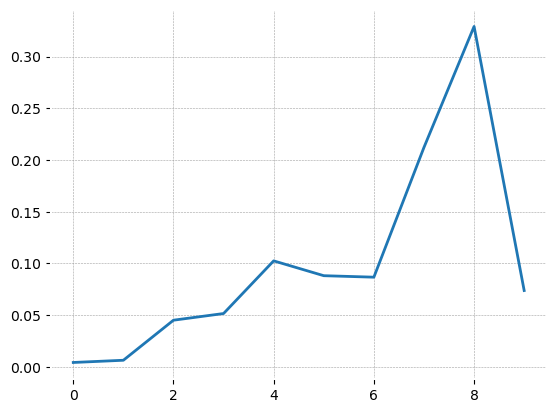

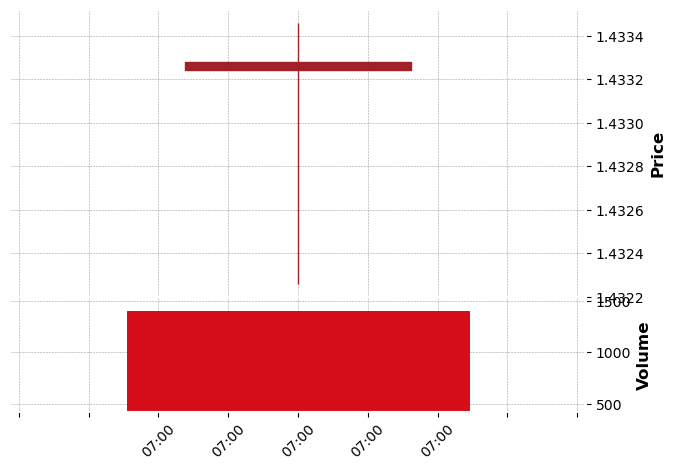

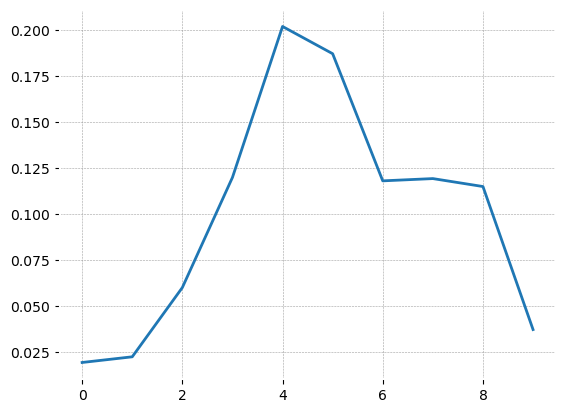

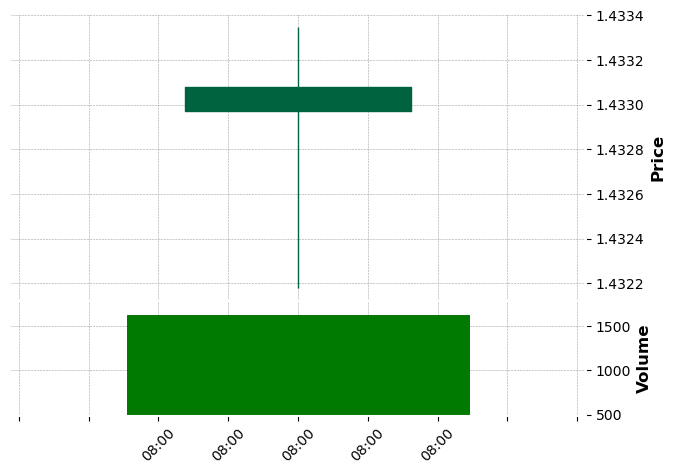

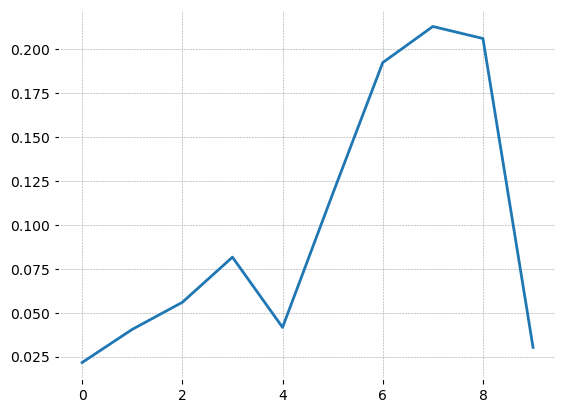

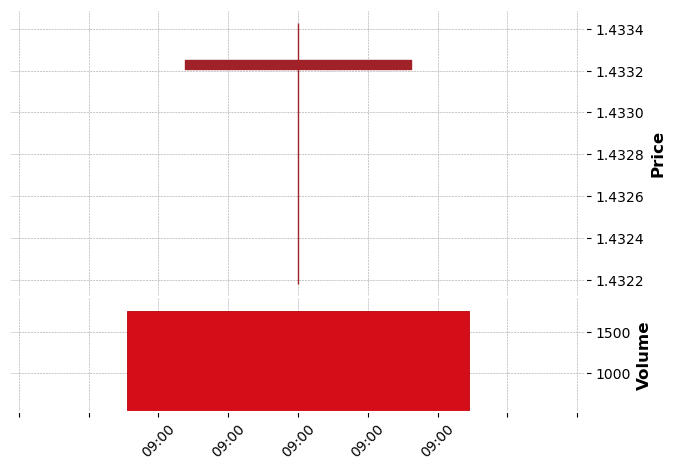

In [9]:
for i in range(1, 10):
    plt.plot(dist[i])
    plt.show()
    mplf_data = pd.DataFrame(tdata[i:i+1, :6], columns = ['Time', 'Open', 'High', 'Low', 'Close' , 'Volume'])
    mplf_data['Time'] = pd.to_datetime(mplf_data['Time'], unit='s') 
    mplf_data.set_index('Time', inplace=True)
    mpf.plot(mplf_data, type='candle', volume=True, style='charles')
    plt.show()
    plt.show()

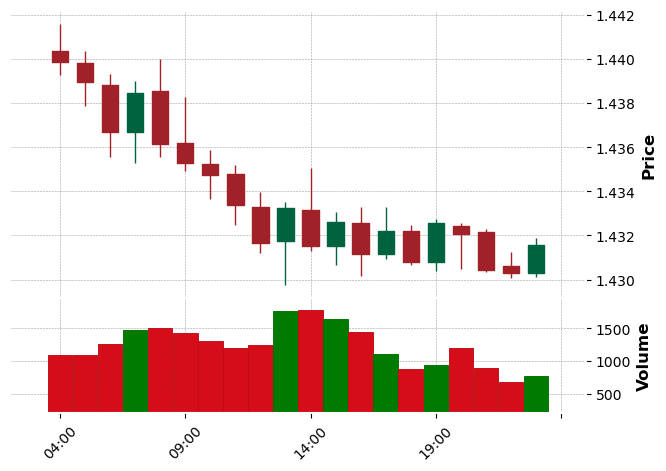

In [10]:
mplf_data = pd.DataFrame(tdata[100:120, :6], columns = ['Time', 'Open', 'High', 'Low', 'Close' , 'Volume'])
mplf_data['Time'] = pd.to_datetime(mplf_data['Time'], unit='s') 
mplf_data.set_index('Time', inplace=True)
mpf.plot(mplf_data, type='candle', volume=True, style='charles')
plt.show()